In [53]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
from random import shuffle
from shutil import copyfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D


COSTANTI

In [57]:
IMG_SIZE = (500, 500)
BATCH_SIZE = 16

DATASET


In [4]:
if(not os.path.isdir("dataset")):
  os.mkdir("dataset/")
  os.mkdir("dataset/covid")
  os.mkdir("dataset/normal")


RADIOGRAFIE PAZIENTI COVID-19

In [5]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 3210 (delta 33), reused 48 (delta 17), pack-reused 3133
Receiving objects: 100% (3210/3210), 582.58 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (1269/1269), done.
Checking out files: 100% (991/991), done.


In [6]:
df = pd.read_csv("/content/covid-chestxray-dataset/metadata.csv")
df.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0,F,52.0,COVID-19,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


Creo filtro per selezionare solo le righe con 'view' = PA, poichè i casi sani hanno solo PA (lastra posteranteriore del torace), e con diagnosi 'finding' = COVID-19

In [7]:
df = df[(df['finding']=='COVID-19') & (df['view']=='PA')]
df.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0,F,52.0,COVID-19,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [8]:
imgs_covid = list(df["filename"])
imgs_covid[:10]

['auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'nejmc2001573_f1a.jpeg',
 'nejmc2001573_f1b.jpeg',
 'lancet-case2a.jpg',
 'lancet-case2b.jpg',
 '1-s2.0-S0140673620303706-fx1_lrg.jpg',
 'nCoV-radiol.2020200269.fig1-day7.jpeg']

In [9]:
imgs_covid_count = len(imgs_covid)
imgs_covid_count

def copy_samples(imgs_list, imgs_path, cls):
  for img in imgs_list:
    copyfile(imgs_path+img, 'dataset/'+ cls + '/' + img)

In [10]:
copy_samples(imgs_covid[:145], 'covid-chestxray-dataset/images/', 'covid')

RADIOGRAFIE PAZIENTI SANI

In [11]:
imgs_normal = os.listdir('/content/drive/My Drive/chest_xray/train/NORMAL')
imgs_normal[:10]
shuffle(imgs_normal)
imgs_normal = imgs_normal[:145]
len(imgs_normal)
copy_samples(imgs_normal, '/content/drive/My Drive/chest_xray/train/NORMAL/', 'normal')

**PREPROCESSING DELLE IMMAGINI**

In [12]:
X = []
y = []

encoding = [('normal', 0), ('covid', 1)]

for folder, label in encoding:
  current_folder = 'dataset/'+folder+'/'
  for img_name in os.listdir(current_folder):
    img = cv2.imread(current_folder + img_name, cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)
    img = cv2.resize(img, IMG_SIZE)/255.

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

X.shape


(290, 200, 200)

In [13]:
def show_sample(X):

  fig = plt.figure()

  for i in range(X.shape[0]):
    plot = fig.add_subplot(1, X.shape[0], i+1)
    plt.imshow(X[i])
    plt.axis('off')


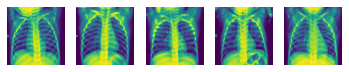

In [61]:
show_sample(X[:5])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [16]:
X_train.shape

(217, 200, 200)

In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

 **DATA AUGMENTATION**
 
 Genero nuove immagini prima ruotando di 15° quelle originali poi aumentandone la luminosità.

In [18]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    brightness_range = [0.2, 1.0]
)

train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size = BATCH_SIZE
)

**ADDESTRAMENTO RETE NEURALE CONVOLUZIONALE**

1.   Primo strato convoluzionale con input(DIMENSIONE IMMAGINE E NUMERO CANALI)

1.   Secondo strato convoluzionale

1.   Terzo strato di Flattening per spacchettare gli array in un unico vettore
2.   Quarto strato denso con 64 neuroni

5.   Quinto strato binario con sigmoidale



In [19]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
model.add(MaxPooling2D(pool_size=2)) 
model.add(Dropout(0.6))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_generator, epochs=100, steps_per_epoch=X_train.shape[0]//BATCH_SIZE)

Epoch 1/100
13/13 [==============================] - 1s 66ms/step - loss: 0.1442 - accuracy: 0.9204
Epoch 2/100
13/13 [==============================] - 1s 65ms/step - loss: 0.0793 - accuracy: 0.9701
Epoch 3/100
13/13 [==============================] - 1s 65ms/step - loss: 0.1342 - accuracy: 0.9552
Epoch 4/100
13/13 [==============================] - 1s 65ms/step - loss: 0.2369 - accuracy: 0.9502
Epoch 5/100
13/13 [==============================] - 1s 66ms/step - loss: 0.1891 - accuracy: 0.9552
Epoch 6/100
13/13 [==============================] - 1s 64ms/step - loss: 0.0636 - accuracy: 0.9701
Epoch 7/100
13/13 [==============================] - 1s 66ms/step - loss: 0.2373 - accuracy: 0.9453
Epoch 8/100
13/13 [==============================] - 1s 65ms/step - loss: 0.2000 - accuracy: 0.9303
Epoch 9/100
13/13 [==============================] - 1s 69ms/step - loss: 0.2189 - accuracy: 0.9453
Epoch 10/100
13/13 [==============================] - 1s 66ms/step - loss: 0.0934 - accuracy: 0.9552

In [35]:
metrics_train = model.evaluate(X_train, y_train)
metrics_test = model.evaluate(X_test, y_test)

print('Train accuracy = %.4f - Train loss = %.4f' % (metrics_train[1],metrics_train[0]))
print('Test accuracy = %.4f - Test loss = %.4f' % (metrics_test[1],metrics_test[0]))

3/3 [==============================] - 0s 13ms/step - loss: 0.1073 - accuracy: 0.9589
Train accuracy = 0.9724 - Train loss = 0.0884
Test accuracy = 0.9589 - Test loss = 0.1073


MATRICE DI CONFUSIONE

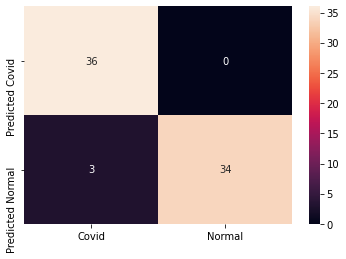

In [36]:
y_pred = model.predict_classes(X_test)

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index=['Predicted Covid', 'Predicted Normal'], columns = ['Covid', 'Normal'])
sn.heatmap(df_cm, annot=True)

COVID O POLMONITE?

creo un dataset di polmoniti NON covid da passare al modello per capire se riesce a distinguere una polmonite 'normale' da una causata da coronavirus.


In [ ]:
os.mkdir('dataset/pneumonia')

In [25]:
imgs_pneumonia = os.listdir('/content/drive/My Drive/chest_xray/train/PNEUMONIA/')
shuffle(imgs_pneumonia)
imgs_pneumonia = imgs_pneumonia[:imgs_covid_count]

copy_samples(imgs_pneumonia, '/content/drive/My Drive/chest_xray/train/PNEUMONIA/', 'pneumonia')

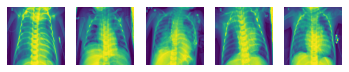

In [60]:
X_pneumonia = []

for img_name in os.listdir('dataset/pneumonia'):

  img = cv2.imread('dataset/pneumonia/' + img_name, cv2.IMREAD_GRAYSCALE)
  img = cv2.equalizeHist(img)
  img = cv2.resize(img,IMG_SIZE)/255
  X_pneumonia.append(img)
  
X_pneumonia = np.array(X_pneumonia)
show_sample(X_pneumonia[:5])

In [39]:
X_pneumonia.shape

(201, 200, 200)

In [40]:
X_pneumonia = X_pneumonia.reshape(X_pneumonia.shape[0], X_pneumonia.shape[1],  X_pneumonia.shape[2], 1)

In [41]:
X_pneumonia.shape

(201, 200, 200, 1)

In [42]:
y_pred = model.predict_classes(X_pneumonia)

POLMONITI NORMALI CLASSIFICATE COME COVID:

In [43]:
misclassified_count = y_pred[y_pred==1].shape[0]
misclassified_count

7

POLMONITI DA CORONAVIRUS CLASSIFICATE COME COVID

In [44]:
pneumonia_samples_count = X_pneumonia.shape[0]
pneumonia_samples_count

201

In [49]:
missclassified_percentage = round(misclassified_count*100/pneumonia_samples_count, 2)
print("Pazienti con polmonite classificati come affetti da COVID-19 = %d/%d (%.2f%%)" % (misclassified_count, pneumonia_samples_count, missclassified_percentage))

Pazienti con polmonite classificati come affetti da COVID-19 = 7/201 (3.48%)


**TEST DELLA RETE NEURALE (ipotizzando di avere nuove lastre)**

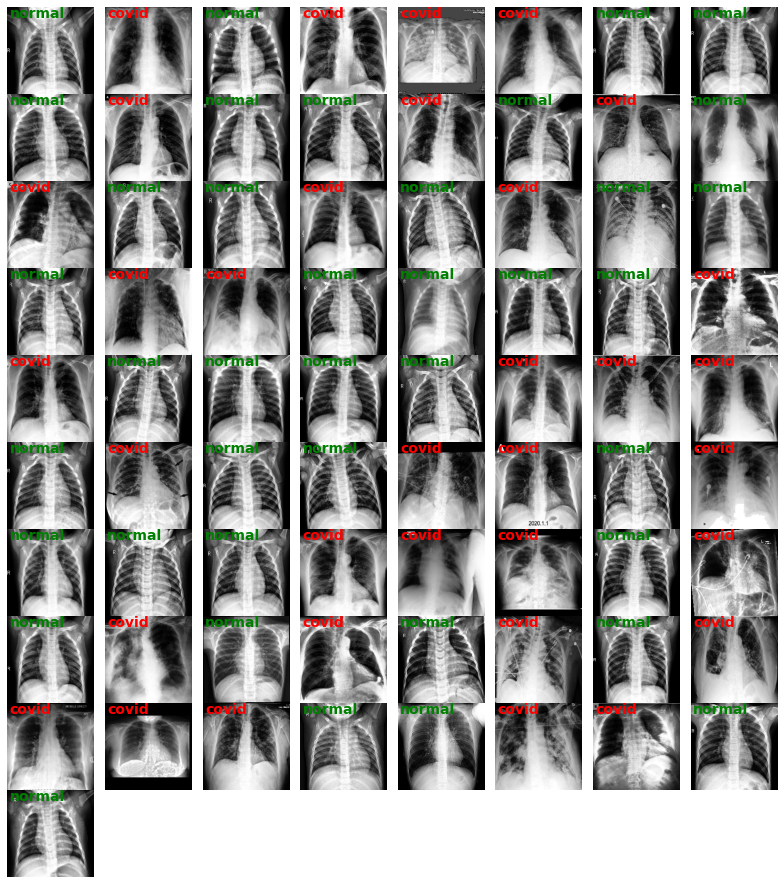

In [62]:
labels = ['normal', 'covid']
colors = ['green', 'red']

pred = model.predict_classes(X_test)

fig = plt.figure(figsize=(14, 16))
fig.subplots_adjust(wspace=0, hspace=0)

n_cols = int(sqrt(X_test.shape[0]))
n_rows = X_test.shape[0]//n_cols+1

for i in range(X_test.shape[0]):
  plot = fig.add_subplot(n_rows, n_cols, i+1)
  plt.imshow(X_test[i].reshape(200, 200), cmap = 'gray')
  class_index = pred[i][0]

  plt.text(5, 25, labels[class_index], fontsize=14, color=colors[class_index], fontdict= {'weight':'bold'})
  plt.axis('off')

